In [1]:
import tensorflow as tf
import tensorflow_cloud as tfc
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from shutil import copyfile

In [2]:
BATCH_SIZE=24

TRAINING_DIR = "dataset_mixed/training"
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,
      featurewise_std_normalization=True,
      featurewise_center=True,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      shear_range=0.2,
      brightness_range=[0.4,1.5],
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    color_mode='rgb',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='sparse',
                                                    target_size=(120, 120))

TESTING_DIR = "dataset_mixed/testing"
testing_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,featurewise_std_normalization=True,
      featurewise_center=True)
testing_generator = testing_datagen.flow_from_directory(TESTING_DIR,
                                                              color_mode='rgb',
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='sparse',
                                                              target_size=(120, 120))

VALIDATION_DIR = "dataset_mixed/validation"
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,featurewise_std_normalization=True,
      featurewise_center=True)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              color_mode='rgb',
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='sparse',
                                                              target_size=(120, 120))

Found 72828 images belonging to 24 classes.
Found 10905 images belonging to 24 classes.
Found 10933 images belonging to 24 classes.


In [209]:
base_model = tf.keras.applications.DenseNet201(weights="imagenet",input_shape=(120,120,3),include_top = False)

In [210]:
# Most of base model will be frozen.
for layer in base_model.layers[:-10]:
    layer.trainable = False
    
last_output = base_model.layers[-1].output

In [211]:
# Last ouput is flattened to get 1D Array for dense network
# Some layers are added to suit more to our problem

core_model = tf.keras.layers.Flatten()(last_output)
core_model = tf.keras.layers.BatchNormalization()(core_model) #To reduce vanishing/exploding gradients problems

core_model = tf.keras.layers.Dense(128,kernel_initializer="he_normal")(core_model)
core_model = tf.keras.layers.BatchNormalization()(core_model) 
core_model = tf.keras.layers.Activation('relu')(core_model)
core_model = tf.keras.layers.Dropout(0.4)(core_model) # To avoid overfitting 

core_model = tf.keras.layers.Dense(64,kernel_initializer="he_normal")(core_model)
core_model = tf.keras.layers.BatchNormalization()(core_model) 
core_model = tf.keras.layers.Activation('relu')(core_model)
core_model = tf.keras.layers.Dropout(0.4)(core_model)

# Final layer is applying softmax function to get multiclass output
output = tf.keras.layers.Dense(24, activation=tf.nn.softmax)(core_model)

my_model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [212]:
optimizer = tf.keras.optimizers.Adam()

my_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [213]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, mode='min', restore_best_weights=True, monitor='val_loss')

In [215]:
history = my_model.fit(train_generator,
                              epochs=50,
                              verbose=1,
                              validation_data=testing_generator,
                              callbacks=[early_stopping])

Epoch 1/50
3035/3035 [==============================] - 346s 111ms/step - loss: 1.9767 - accuracy: 0.3805 - val_loss: 1.0094 - val_accuracy: 0.6652
Epoch 2/50
3035/3035 [==============================] - 325s 107ms/step - loss: 1.4383 - accuracy: 0.5365 - val_loss: 0.8406 - val_accuracy: 0.7210
Epoch 3/50
3035/3035 [==============================] - 290s 96ms/step - loss: 1.2578 - accuracy: 0.5981 - val_loss: 0.7121 - val_accuracy: 0.7686
Epoch 4/50
3035/3035 [==============================] - 291s 96ms/step - loss: 1.1274 - accuracy: 0.6435 - val_loss: 0.5874 - val_accuracy: 0.8061
Epoch 5/50
3035/3035 [==============================] - 292s 96ms/step - loss: 1.0451 - accuracy: 0.6719 - val_loss: 0.5061 - val_accuracy: 0.8341
Epoch 6/50
3035/3035 [==============================] - 294s 97ms/step - loss: 0.9754 - accuracy: 0.6965 - val_loss: 0.5242 - val_accuracy: 0.8313
Epoch 7/50
3035/3035 [==============================] - 302s 100ms/step - loss: 0.9175 - accuracy: 0.7156 - val_loss

In [175]:
my_model.evaluate(validation_generator)

456/456 [==============================] - 24s 52ms/step - loss: 0.1022 - accuracy: 0.9659


[0.10221806913614273, 0.9658831357955933]

In [188]:
ALL = "photo_test"
ONLY_HAND = "photo_test-only_hand"
OLD_DATASET = "dataset_mixed/validation"
FROM_VIDEO = "photo_from_video/validation"

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

all_photo_gen = validation_datagen.flow_from_directory(ALL,
                                                      color_mode='rgb',
                                                      batch_size=1,
                                                      class_mode='sparse',
                                                      target_size=(120, 120))

only_hand_gen = validation_datagen.flow_from_directory(ONLY_HAND,
                                                      color_mode='rgb',
                                                      batch_size=1,
                                                      class_mode='sparse',
                                                      target_size=(120, 120))

old_data_gen = validation_datagen.flow_from_directory(OLD_DATASET,
                                                      color_mode='rgb',
                                                      batch_size=24,
                                                      class_mode='sparse',
                                                      target_size=(120, 120))

from_video_data_gen = validation_datagen.flow_from_directory(FROM_VIDEO,
                                                      color_mode='rgb',
                                                      batch_size=2,
                                                      class_mode='sparse',
                                                      target_size=(120, 120))

Found 24 images belonging to 24 classes.
Found 24 images belonging to 24 classes.
Found 10933 images belonging to 24 classes.
Found 306 images belonging to 24 classes.


In [186]:
my_model.evaluate(all_photo_gen)

24/24 [==============================] - 2s 89ms/step - loss: 28.1763 - accuracy: 0.0417


[28.176307678222656, 0.0416666679084301]

In [189]:
my_model.evaluate(only_hand_gen)

24/24 [==============================] - 1s 41ms/step - loss: 1.0155 - accuracy: 0.7083


[1.0154985189437866, 0.7083333134651184]

In [179]:
my_model.evaluate(old_data_gen)

456/456 [==============================] - 22s 48ms/step - loss: 0.1022 - accuracy: 0.9659


[0.10221806913614273, 0.9658831357955933]

In [184]:
my_model.evaluate(from_video_data_gen)

153/153 [==============================] - 6s 42ms/step - loss: 0.0689 - accuracy: 0.9706


[0.06893455982208252, 0.970588207244873]

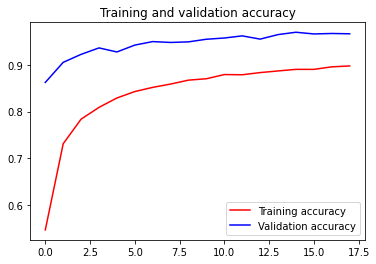

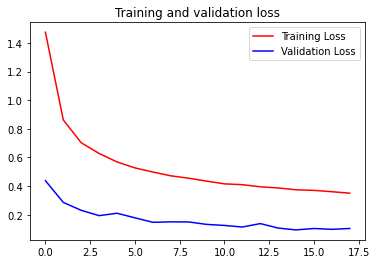

In [197]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

fig = plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [198]:
my_model.save('model/DenseNet201_120_rgb_full_da_full_layers_add.h5')